# Итоговая работа по курсу "Введение в нейронные сети"

**Требования к курсовому проекту:**

Оформить ноутбук со следующими этапами:

1. Знакомство с данными (визуализация, вывод примеров, меток классов/значений целевой переменной)
2. Предобработка (нормализация, оформление генератора, аугментации)
3. Эксперименты с моделями
4. Валидация модели
5. Инференс модели (работа модели на тестовых объектах, если это соревнование - генерация csv для сабмита)
6. Выводы по работе (интерпретация результатов, что можно ещё поделать, чего не хватило, планы на будущее)

## 1. Знакомство с данными

Набор данных Labeled Faces in the Wild содержит более 13000 фотографий лиц, собранных в интернете. 
Каждое фото сопровождается именем изображенного на нем человека. 
1680 человек имеют 2 или более различных фото в датасете. 

Изображения имеют формат JPEG.
Более подробную информацию можно получить по [ссылке](http://vis-www.cs.umass.edu/lfw/).

В центре каждого изображения одно лицо. Каждый пиксель каждого канала зашифрован в диапазоне 0.0 - 1.0 (цвет в RGB).

Решается задача распознавания лиц (идентификации). Дана картинка с лицом человека. Найти его имя из тренировочного набора (галереи).

Оригинальные картинки имеют размер 250x250 пикселей, но дефолтные функции slice и resize уменьшают их до 62x47 пикселей.

In [ ]:
RANDOM_SEED = 42

In [ ]:
import sklearn
from os import path
from sklearn.datasets import fetch_lfw_people

path="/content/drive/MyDrive/Colab Notebooks/coursework/lfw"

lfw_dataset=sklearn.datasets.fetch_lfw_people(
    data_home=path,
    min_faces_per_person=100,
    download_if_missing=True
)

Смотрим размеры загруженного датасета

In [ ]:
print(lfw_dataset.images.shape)
print(lfw_dataset.data.shape)
print(lfw_dataset.target_names.shape)
print(lfw_dataset.target.shape)

(1140, 62, 47)
(1140, 2914)
(5,)
(1140,)


Выведем одно из изображений датасета на экран

In [ ]:
from PIL import Image
from matplotlib import cm
import numpy as np

image = lfw_dataset.images[0]
PIL_image = Image.fromarray(np.uint8(image)).convert('RGB')

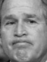

In [ ]:
PIL_image

Посмотрим на целевую переменную (представляет собой id людей, изображенных на фото)

In [ ]:
lfw_dataset.target

array([2, 3, 1, ..., 4, 2, 4])

In [ ]:
names = lfw_dataset.target_names

In [ ]:
names

array(['Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Tony Blair'], dtype='<U17')

Это имена пятерых людей, на фотках которых будет учиться нейронка.

In [ ]:
N=[]
for i in range(len(names)):
    N+=[i]
    
mapping=dict(zip(names,N)) 
reverse_mapping=dict(zip(N,names)) 

def mapper(value):
    return reverse_mapping[value]

In [ ]:
N

[0, 1, 2, 3, 4]

Оформим два словарика id -> Имя и Имя -> id

In [ ]:
mapping

{'Colin Powell': 0,
 'Donald Rumsfeld': 1,
 'George W Bush': 2,
 'Gerhard Schroeder': 3,
 'Tony Blair': 4}

In [ ]:
reverse_mapping

{0: 'Colin Powell',
 1: 'Donald Rumsfeld',
 2: 'George W Bush',
 3: 'Gerhard Schroeder',
 4: 'Tony Blair'}

Вытащим из набора данных X и y. И начнем оформлять тренировочные и валидационные датасеты.

In [ ]:
X = lfw_dataset.images.reshape(-1,62,47,1)
y = lfw_dataset.target

In [ ]:
dataset=[]
testset=[]
t=0
for Xi,yi in zip(X,y):
    img=Xi/255.0
    if t<=200:
        dataset.append([img,yi])
    else:   
        testset.append([img,yi])
    t+=1

In [ ]:
data, labels_0 = zip(*dataset)
test, test_labels_0 = zip(*testset)

Сделаем кодирование с использованием OHE (готовим к разбиению train_test_split)

In [ ]:
from tensorflow.keras.utils import to_categorical

labels=np.array(to_categorical(labels_0))
data=np.array(data)

test_labels=np.array(to_categorical(test_labels_0))
test=np.array(test)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=RANDOM_SEED)

## 2. Сделаем аугментацию изображений с целью искусственного увеличения выборки

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
image_data_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    fill_mode="nearest"
)

## 3. Соберем сверточную нейронную сеть (перебирал несколько вариантов, оставил наилучший в плане лаконичности и точности)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy

num_classes = 5

# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

# компиляция модели
model.compile(loss=categorical_crossentropy,
              optimizer='Adam',
              metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 47, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 23, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 23, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 11, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 5, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 3, 128)        

Обучаем сеть

In [ ]:
history=model.fit(
    image_data_generator.flow(
        X_train, y_train, batch_size=512
    ),
    validation_data=(X_test, y_test),
    epochs=1000
)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 1.6025 - accuracy: 0.4500 - val_loss: 1.5285 - val_accuracy: 0.5366
Epoch 2/1000
1/1 [==============================] - 1s 622ms/step - loss: 1.5487 - accuracy: 0.4500 - val_loss: 1.3981 - val_accuracy: 0.5366
Epoch 3/1000
1/1 [==============================] - 1s 625ms/step - loss: 1.4627 - accuracy: 0.4500 - val_loss: 1.3914 - val_accuracy: 0.5366
Epoch 4/1000
1/1 [==============================] - 1s 627ms/step - loss: 1.5360 - accuracy: 0.4500 - val_loss: 1.3280 - val_accuracy: 0.5366
Epoch 5/1000
1/1 [==============================] - 1s 641ms/step - loss: 1.4252 - accuracy: 0.4500 - val_loss: 1.3746 - val_accuracy: 0.5366
Epoch 6/1000
1/1 [==============================] - 1s 622ms/step - loss: 1.4444 - accuracy: 0.4500 - val_loss: 1.3782 - val_accuracy: 0.5366
Epoch 7/1000
1/1 [==============================] - 1s 631ms/step - loss: 1.4490 - accuracy: 0.4500 - val_loss: 1.3447 - val_accuracy: 0.5366
Epoch 8/1

## 4. Валидируем модель

In [ ]:
from sklearn.metrics import classification_report

y_pred=model.predict(X_test)
target_pred=np.argmax(y_pred, axis=1)
target_test=np.argmax(y_test, axis=1)
print(classification_report(target_test, target_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5
           2       0.92      1.00      0.96        22
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00         4

    accuracy                           0.93        41
   macro avg       0.76      0.76      0.76        41
weighted avg       0.88      0.93      0.90        41



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Отличный результат по F-score. Теперь визуализируем итоговые предсказания.

In [ ]:
from matplotlib import pyplot as plt

def plot_gallery(images, titles, h, w, n_row=1, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

(4, 62, 47, 1)
(4, 2914)


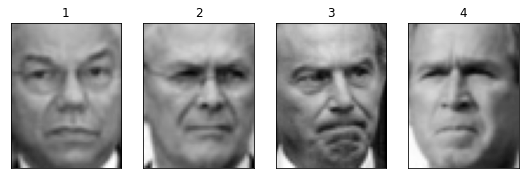

In [ ]:
test1=test[4:8].reshape(4,62*47)
plot_gallery(test1,'1234',62,47)
print(test[0:4].shape)
print(test1.shape)

In [ ]:
prediction_image=test[4:8]
prediction=model.predict(prediction_image)

for i in range(4):
    value=np.argmax(prediction[i])
    name=mapper(value)
    print("Prediction {} is {}.".format(i+1,name))

Prediction 1 is Colin Powell.
Prediction 2 is Donald Rumsfeld.
Prediction 3 is Tony Blair.
Prediction 4 is George W Bush.


## Вывод:

Сверточная нейросеть с лекции хорошо справилась с задачей классификации.
В качестве развития можно доучить сеть на других новых для распознавания более широкого круга лиц.
В целом применить можно например для атоматизации умного дома или для ограничения доступа детей к компьютеру (распознавать взрослых и разблокировать систему только для них, а блокировать когда взрослый встал из-за компьютера).